# Object Classification Using AlexNet on Imagenette Dataset
*For more details, check github: https://github.com/RahulRewale/computer-vision/tree/main/projects/object-classification*

### Install and import required libraries

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=ef6226aec90635bca738a4ec95512d365280338120d3528dd39d23e975202f41
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# load all the required packages
import os
import wget
import glob
import time
#import gc
#import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

### Create variables for storing some paths

In [ ]:
data_folder = 'data'
dataset_folder = os.path.join(data_folder, 'imagenette2')
dataset_tar_file_name = 'imagenette2.tgz'
dataset_path = os.path.join(data_folder, dataset_tar_file_name)
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
classes = ['Tench', 'English Springer', 'Cassette Player', 'Chain Saw', 'Church', 
			'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute']

### Download Imagenette dataset and extract it

In [ ]:
if not os.path.exists('data'):
  os.makedirs('data')

In [ ]:
!wget -nc {dataset_url}  -O {dataset_path}
!tar -xvzf {dataset_path} -C {data_folder}

Streaming output truncated to the last 5000 lines.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n03888257_18127.JP

### Create a class for loading and pre-processing training, validation, testing dataset

In [ ]:
class DataLoader():
  """Class to load training, validation, and testing data"""
  
  def __init__(self, train_dir, val_dir, test_dir=None):
    """ Sets the directories from where data should be loaded

    Parameters:
    train_dir: directory containing the training data
    val_dir: directory containing the validation data
    test_dir: directory containing the testing data
    """

    self.train_dir = train_dir
    self.val_dir = val_dir
    self.test_dir = val_dir
    if test_dir:
      self.test_dir = test_dir
  

  ###############################
  def load_train_ds(self, batch_size=32, image_size=(256, 256)):
    """Loads testing and validation data
    
    Parameter:
    batch_size: batch size for loading data
    image_size: target image size that we want for images
    """

    train_ds = K.preprocessing.image_dataset_from_directory(
				directory = self.train_dir,
				label_mode = 'categorical',
				batch_size = 4,
        # manually set to 4; after generating crops, user specified 
        # batch_size will be used
				image_size = image_size,
				)
    
    self.class_names = train_ds.class_names

    train_ds = train_ds.map(lambda x, y: self.custom_extract_crops(x/255.0, y), )
    train_ds = train_ds.unbatch().shuffle(5000).batch(batch_size)

    print(train_ds.cardinality())
    for batch_x, batch_y in train_ds.take(2):
      print(batch_x.shape)
      print(batch_y.shape)

    return train_ds


  ###############################
  def load_val_test_ds(self, batch_size=64, image_size=(256, 256), val_split=0.3):
    """Loads testing and validation data
    
    Parameter:
    batch_size: batch size for loading data
    image_size: target image size that we want for images
    val_split: if val_dir and test_dir are same, data will be split
    """

    all_ds = K.preprocessing.image_dataset_from_directory(
					  directory=self.val_dir,
            label_mode='categorical',
					  image_size=image_size,
            batch_size=batch_size
				  )

    if self.test_dir != self.val_dir:
      val_ds = all_ds
      test_ds = K.preprocessing.image_dataset_from_directory(
					      directory=self.test_dir,
                label_mode='categorical',
					      image_size=image_size,
                batch_size=batch_size
				      )
    else:
      total_size = all_ds.cardinality()
      val_ds = all_ds.take(total_size.numpy() * val_split)
      test_ds = all_ds.skip(total_size.numpy() * val_split)

    val_ds = val_ds.map(lambda x, y: self.extract_five_crops(x/255.0, y))
    test_ds = test_ds.map(lambda x, y: self.extract_five_crops(x/255.0, y))

    print(val_ds.cardinality())
    for batch_x, batch_y in val_ds.take(2):
      print(batch_x.shape)
      print(batch_y.shape)

    return val_ds, test_ds


  #############################
  def custom_extract_crops(self, batch_x, batch_y):
    """ 
      Creates patches for a batch of images
    
      Parameters:
      batch_x: batch of images
      batch_y: batch of labels for the above images
    """
    
    patch_size = 227
    # stride 3 creates 100 patches from each image
    # stride 6 creates 25 patches from each image
    # stride 9 creates 16 patches from each image
    stride = 9
    patches = tf.image.extract_patches(batch_x, sizes=[1, patch_size, patch_size, 1], strides=[1, stride, stride, 1], rates=[1,1,1,1], padding='VALID')
    row_patches = ((256 - patch_size)//stride) + 1
    no_patches = row_patches*row_patches
    print("Number of patches generated from each training image: ", 2*no_patches)

    patches = tf.reshape(patches,  (-1, patch_size, patch_size, 3))
    flipped_patches = tf.image.flip_left_right(patches)
    
    patches = tf.reshape(patches,  (-1, no_patches, patch_size, patch_size, 3))
    flipped_patches = tf.reshape(flipped_patches,  (-1, no_patches, patch_size, patch_size, 3))

    final_patches = tf.concat((patches, flipped_patches), axis=1)
    final_patches = tf.reshape(final_patches, (-1, patch_size, patch_size, 3))
    
    labels = tf.repeat(batch_y, repeats=2*no_patches, axis=0)
    labels = tf.reshape(labels, (-1, 10))

    return final_patches, labels
  
  
  #############################
  def extract_five_crops(self, batch_x, batch_y):

    # take 4 patches from corners of the image of size (256, 256)
    raw_patches = tf.image.extract_patches(batch_x, sizes=[1, 227, 227, 1], strides=[1, 29, 29, 1], rates=[1,1,1,1], padding="VALID")
    patches = tf.reshape(raw_patches, (-1,)+(227, 227, 3))
    flipped_patches = tf.image.flip_left_right(patches)
    
    patches = tf.reshape(patches, (-1, 4) + (227, 227, 3))
    flipped_patches = tf.reshape(flipped_patches, (-1, 4) + (227, 227, 3))
    
    # take central crop from the image
    central_patches = tf.image.resize(tf.image.central_crop(batch_x, 0.88), (227, 227))
    flipped_central_patches = tf.image.flip_left_right(central_patches)
    
    #increase dimensions by one to be able to concatenate
    central_patches = central_patches[:, tf.newaxis, ...]
    flipped_central_patches = flipped_central_patches[:, tf.newaxis, ...]
    
    # concatenate above to create 10 patches per image
    final_patches = tf.concat((patches, central_patches, flipped_patches, flipped_central_patches), axis=1)
    
    return final_patches, batch_y


### Define AlexNet Architecture in a class

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as tfl


class AlexNet(K.models.Model):
  """This class extends Keras Model class and creates an AlexNet model"""

  def __init__(self, dense_units=512, drop=0.6, weight_decay=0.008, classes=10):
    """
      Creates all the required layers using Keras
      
      Parameters:
      dense_units: no. of units in the dense layers
      drop: dropout for the dense layers
      weight_decay: weight decay for all conv. layers
      classes: no. of categories/classes of objects
    """

    super().__init__()

    self.conv1 = tfl.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
          activation='relu', kernel_initializer='he_normal', 
          kernel_regularizer=K.regularizers.L2(weight_decay))
    # Skipped Local Response Normalization layer from AlexNet as it is proven to be not that useful
    self.batch_norm1 = tfl.BatchNormalization()
    self.pool1 = tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))

    self.conv2 = tfl.Conv2D(filters=256, kernel_size=(5, 5), padding='same', 
          activation='relu', kernel_initializer='he_normal',
          kernel_regularizer=K.regularizers.L2(weight_decay))
    self.batch_norm2 = tfl.BatchNormalization()
    # Skipped Local Response Normalization layer
    self.pool2 = tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))

    self.conv3 = tfl.Conv2D(filters=384, kernel_size=(3, 3), padding='same', 
          activation='relu', kernel_initializer='he_normal',
          kernel_regularizer=K.regularizers.L2(weight_decay))
    self.batch_norm3 = tfl.BatchNormalization()
    self.conv4 = tfl.Conv2D(filters=384, kernel_size=(3, 3), padding='same', 
          activation='relu', kernel_initializer='he_normal',
          kernel_regularizer=K.regularizers.L2(weight_decay))
    self.batch_norm4 = tfl.BatchNormalization()
    self.conv5 = tfl.Conv2D(filters=256, kernel_size=(3, 3), padding='same', 
          activation='relu', kernel_initializer='he_normal',
          kernel_regularizer=K.regularizers.L2(weight_decay))
    self.batch_norm5 = tfl.BatchNormalization()
    self.pool3 = tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))

    # FC layers with dropout
    self.flat = tfl.Flatten()
    self.dense1 = tfl.Dense(units=dense_units, activation='relu', 
                            kernel_initializer='he_normal')
    self.drop1 = tfl.Dropout(rate=drop)
    self.dense2 = tfl.Dense(units=dense_units, activation='relu',
                            kernel_initializer='he_normal')
    self.drop2 = tfl.Dropout(rate=drop)
    
    # output layer
    self.classifier = tfl.Dense(units=classes, activation='softmax')


  def call(self, inputs, training=None):
    """Processes inputs through the alexnet layers and returns output"""

    out = inputs
    out = self.conv1(out)
    out = self.batch_norm1(out, training=training)
    out = self.pool1(out)
    out = self.conv2(out)
    out = self.batch_norm2(out, training=training)
    out = self.pool2(out)
    out = self.conv3(out)
    out = self.batch_norm3(out, training=training)
    out = self.conv4(out)
    out = self.batch_norm4(out, training=training)
    out = self.conv5(out)
    out = self.batch_norm5(out, training=training)
    out = self.pool3(out)
    out = self.flat(out)
    out = self.dense1(out)
    out = self.drop1(out, training=training)
    out = self.dense2(out)
    out = self.drop2(out, training=training)
    return self.classifier(out)

### Create some variables required during training, validation, and testing

In [ ]:
batch_size = 128
image_size = (256,256)

dense_units = 64
drop = 0.5
weight_decay = 0.00001

lr = 1e-4
start_epoch = 0
epochs = 25

losses = []
val_losses = []
val_losses_lr_update = []
accuracies = []
val_accuracies = []

In [ ]:
output_dir = os.path.join('results', f'ckpt-units-{dense_units}-drop-{drop}-wd-{weight_decay}')
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

### Load data

In [ ]:
# load data
ds_loader = DataLoader(os.path.join(dataset_folder, 'train'), os.path.join(dataset_folder, 'val'))
train_ds = ds_loader.load_train_ds(batch_size=batch_size)
val_ds, test_ds = ds_loader.load_val_test_ds(batch_size=batch_size)

Found 9469 files belonging to 10 classes.
Number of patches generated from each training image:  32
tf.Tensor(-2, shape=(), dtype=int64)
(128, 227, 227, 3)
(128, 10)
(128, 227, 227, 3)
(128, 10)
Found 3925 files belonging to 10 classes.
tf.Tensor(9, shape=(), dtype=int64)
(128, 10, 227, 227, 3)
(128, 10)
(128, 10, 227, 227, 3)
(128, 10)


### Create AlexNet Model

In [ ]:
alex_net = AlexNet(dense_units=dense_units, drop=drop, weight_decay=weight_decay)

### Load pre-trained model to fine-tune

In [ ]:
# alex_net = K.models.load_model(os.path.join(output_dir, f'lr-0.002100-ep-10')) # update path as required
# start_epoch = 31
# epochs = 37   # epochs
# optimizer.learning_rate = 0.001470 # use smaller LR

### Create optimizer, losses, and metrics for training

In [ ]:
# optimizer
# optimizer = K.optimizers.SGD(learning_rate=lr, momentum=0.9)
optimizer = K.optimizers.Adam(learning_rate=lr)

# loss function
loss_obj = K.losses.CategoricalCrossentropy()

# training metrics and loss
train_mean_loss = K.metrics.Mean()
train_cat_acc = K.metrics.CategoricalAccuracy()

# validation/testing metrics and loss
mean_loss = K.metrics.Mean()
cat_acc = K.metrics.CategoricalAccuracy()

### Training function using GradientTape

In [ ]:
@tf.function
def train_step(batch_x, batch_y):
  """Trains the model on one batch of data"""

  with tf.GradientTape() as tape:
    pred = alex_net(batch_x, training=True)
    loss = loss_obj(batch_y, pred)

  grads = tape.gradient(loss, alex_net.trainable_variables)
  optimizer.apply_gradients(zip(grads, alex_net.trainable_variables))
  train_mean_loss(loss)
  train_cat_acc.update_state(batch_y, pred)

### Function to compute loss and metrics on a given dataset

In [ ]:
# TODO - convert this to tf.function to speed up
def compute_metrics(ds):
  """Computes loss and accuracy on the given dataset ds"""

  cat_acc.reset_states()
  mean_loss.reset_states()
  for batch_x, batch_y in iter(ds):
    pred = alex_net(tf.reshape(batch_x, (-1, 227, 227, 3)), training=False)
    pred = tf.reshape(pred, (-1, 10, 10))
    pred = tf.reduce_mean(pred, axis=1)
    loss = loss_obj(batch_y, pred)
    mean_loss(loss)
    cat_acc.update_state(batch_y, pred)

### Custom function to reduce LR on plateau

In [ ]:
def change_LR():
  if len(val_losses_lr_update) < 4:
    return False

  if any(np.array(val_losses_lr_update)[-3:] <= (val_losses_lr_update[-4]-0.05)):
    return False
  
  return True

### Train, validate, and test the model

In [ ]:
# train_ds.cardinality() returns invalid value; 
# thus, set it to 0 initially, and correct it after first epoch
no_of_train_batches = 0

print("Number of dense units:", dense_units)
print("Dropout rate:", drop)
print("Weight Decay:", weight_decay)

for epoch in range(start_epoch, epochs):

  print(f"\n\nEpoch {epoch+1}/{epochs}:")
  print(f"Learning rate: {optimizer.learning_rate.numpy():.6f}")
  
  # shuffle data before each epoch -- program crashes during shuffling
  # there is memory leak in tensorflow - https://github.com/tensorflow/tensorflow/issues/31312
  # used_mem = psutil.virtual_memory().used
  # print("used memory: {} Mb".format(used_mem / 1024 / 1024))
  # train_ds = train_ds.unbatch().shuffle(3000).batch(batch_size)
  
  train_mean_loss.reset_states()
  train_cat_acc.reset_states()
  
  batch_no = 0
  for batch_x, batch_y in iter(train_ds):
    batch_no += 1
    train_step(batch_x, batch_y)
    if batch_no%500 == 0:
      print(f"\tLoss for {batch_no}/{no_of_train_batches}: {train_mean_loss.result()}")

  no_of_train_batches = batch_no  # get correct cardinality of the dataset

  print(f"\nTraining Metrics: Loss {train_mean_loss.result()}; Accuracy {train_cat_acc.result()}")
  losses.append(train_mean_loss.result().numpy())
  accuracies.append(train_cat_acc.result().numpy())

  compute_metrics(val_ds)
  print(f"Validation Metrics: Loss {mean_loss.result()}; Accuracy {cat_acc.result()}")
  val_losses.append(mean_loss.result().numpy())
  val_losses_lr_update.append(mean_loss.result().numpy())
  val_accuracies.append(cat_acc.result().numpy())

  alex_net.save(os.path.join(output_dir, f'lr-{optimizer.learning_rate.numpy():.6f}-ep-{epoch}'))

  # if change_LR() and optimizer.learning_rate.numpy() > 0.0001: # for sgd
  if change_LR() and optimizer.learning_rate.numpy() > 0.00001:  # for adam
    optimizer.learning_rate = optimizer.learning_rate * 0.7
    val_losses_lr_update.clear()
  
  # recommended approach to resolve memory leak - doesn't work
  # gc.collect()
  # K.backend.clear_session()

# test model on test data
compute_metrics(test_ds)
print(f"\n\nTesting Metrics: Loss {mean_loss.result()}; Accuracy {cat_acc.result()}")

losses.append(0)
accuracies.append(0)
val_losses.append(mean_loss.result().numpy())
val_accuracies.append(cat_acc.result().numpy())

# save model history to a csv file
df = pd.DataFrame(np.vstack((losses, val_losses, accuracies, val_accuracies)).T, columns=["loss", "val_loss", "accuracy", "val_accuracy"])
df.to_csv(os.path.join(output_dir, f'hist-eps-{epochs}.csv'))

Number of dense units: 64
Dropout rate: 0.5
Weight Decay: 1e-05


Epoch 1/25:
Learning rate: 0.000100
	Loss for 500/0: 2.2168209552764893
	Loss for 1000/0: 2.08054518699646
	Loss for 1500/0: 1.974661946296692
	Loss for 2000/0: 1.8576105833053589

Training Metrics: Loss 1.7941408157348633; Accuracy 0.358766108751297
Validation Metrics: Loss 1.2974538803100586; Accuracy 0.6293402910232544
INFO:tensorflow:Assets written to: results/ckpt-units-64-drop-0.5-wd-1e-05/lr-0.000100-ep-0/assets


Epoch 2/25:
Learning rate: 0.000100
	Loss for 500/2368: 1.4118448495864868
	Loss for 1000/2368: 1.3902528285980225
	Loss for 1500/2368: 1.3800640106201172
	Loss for 2000/2368: 1.3457343578338623

Training Metrics: Loss 1.3261727094650269; Accuracy 0.547662079334259
Validation Metrics: Loss 1.0976223945617676; Accuracy 0.6805555820465088
INFO:tensorflow:Assets written to: results/ckpt-units-64-drop-0.5-wd-1e-05/lr-0.000100-ep-1/assets


Epoch 3/25:
Learning rate: 0.000100
	Loss for 500/2368: 1.20080828666

### Plot some samples from test data

(128, 10, 227, 227, 3)


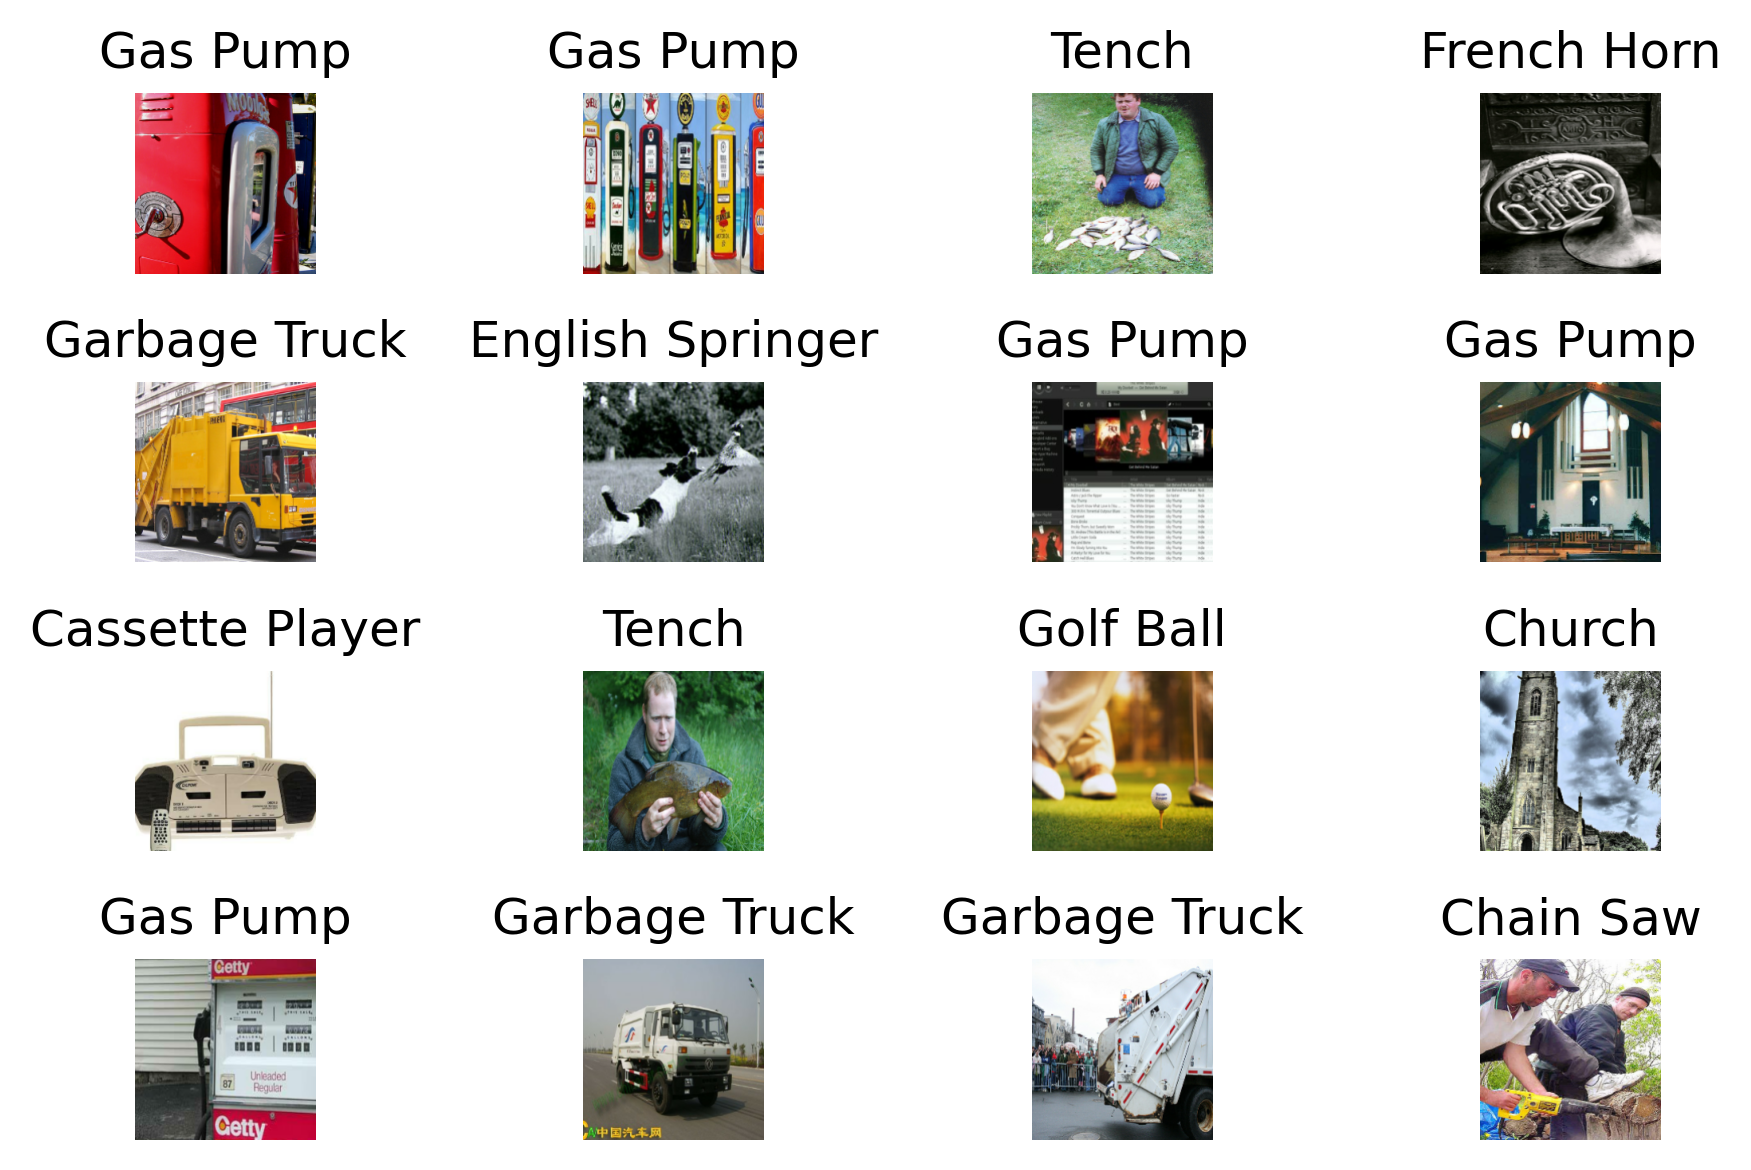

In [ ]:
batch_x, batch_y = next(test_ds.as_numpy_iterator())
pred = alex_net(tf.reshape(batch_x, (-1, 227, 227, 3)), training=False)
pred = tf.reshape(pred, (-1, 10, 10))
pred = tf.reduce_mean(pred, axis=1).numpy()
print(batch_x.shape)

for i in range(16):	# plot few images from the batch
	plt.subplot(4, 4, i+1)
	plt.imshow(batch_x[i, 4])	# take the central crop (4th) for displaying
	plt.title(classes[np.argmax(pred[i])])
	plt.axis('off')

plt.tight_layout()
# save the figure
plt.savefig(os.path.join(output_dir, f'test-eps-{epochs}.png'))

### Load any checkpoint and compute losses and metrics on validation and test data

In [ ]:
# specify the path of the checkpoint that you want to test
new_model = K.models.load_model(os.path.join(output_dir, f'lr-0.000024-ep-24'))

def compute_test(ds):
  cat_acc.reset_states()
  mean_loss.reset_states()
  for batch_x, batch_y in iter(ds):
    pred = new_model(tf.reshape(batch_x, (-1, 227, 227, 3)), training=False)
    pred = tf.reshape(pred, (-1, 10, 10))
    pred = tf.reduce_mean(pred, axis=1)
    loss = loss_obj(batch_y, pred)
    mean_loss(loss)
    cat_acc.update_state(batch_y, pred) 

compute_test(val_ds)
print(f"\n\nValidation Metrics: Loss {mean_loss.result()}; Accuracy {cat_acc.result()}")
compute_test(test_ds)
print(f"\n\nTesting Metrics: Loss {mean_loss.result()}; Accuracy {cat_acc.result()}")



Validation Metrics: Loss 0.5623897910118103; Accuracy 0.8680555820465088


Testing Metrics: Loss 0.606745719909668; Accuracy 0.8514244556427002


### Mount Google Drive and save results of the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r {output_dir} {os.path.join('drive', 'MyDrive', 'Colab\ Notebooks', 'Object\ Classification', 'AlexNet')}

### If you want to clear all saved checkpoints

In [ ]:
#!rm -rf results